In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from stochastic_dynamics.models import DeepLagEmbed
from stochastic_dynamics.generators import tvar
from stochastic_dynamics.utils import train_loop, bench_loop
from stochastic_dynamics.plottings import plot_history, plot_coefficients_by_p, plot_tvar_sample

from torchinfo import summary

In [ ]:
d = np.load('model/tvar_dataset.npz')
X_train, coef_train, \
    p_train, X_val, coef_val, p_val = [d[k][:] for k in ['X_train', 'coef_train', 
                                                      'p_train', 'X_val', 'coef_val', 'p_val']]
d.close()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.init()
print(f"Using device: {device}")

# To tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
p_train = torch.tensor(p_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
p_val = torch.tensor(p_val, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_train, p_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, p_val), batch_size=32)

Using device: cuda


In [5]:
def do_bench_on_config(lambda_config):
    
    # hyperparameters
    n_epochs = 20
    lr = 1e-3
    max_ar_order = 6
    

    # Model: n_classes=5 for p∈{2,3,4,5,6}, max_ar_order=6 for coefficient dimensions
    model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    model = model.to(device)

    # summary(model, input_size=(32, 600), device=device)

    # Train
    history = train_loop(
        model, train_loader, val_loader,
        n_epochs=n_epochs, lr=lr,
        lambda_p=lambda_config["lambda_p"], lambda_ar=lambda_config["lambda_ar"], lambda_energy=lambda_config["lambda_energy"], 
        lambda_smooth=lambda_config["lambda_smooth"], lambda_order=lambda_config["lambda_order"],
        p_max=max_ar_order, device=device
    )
    return model, history

Training: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s, p_acc=0.444, train=0.0981, val=14.6243]


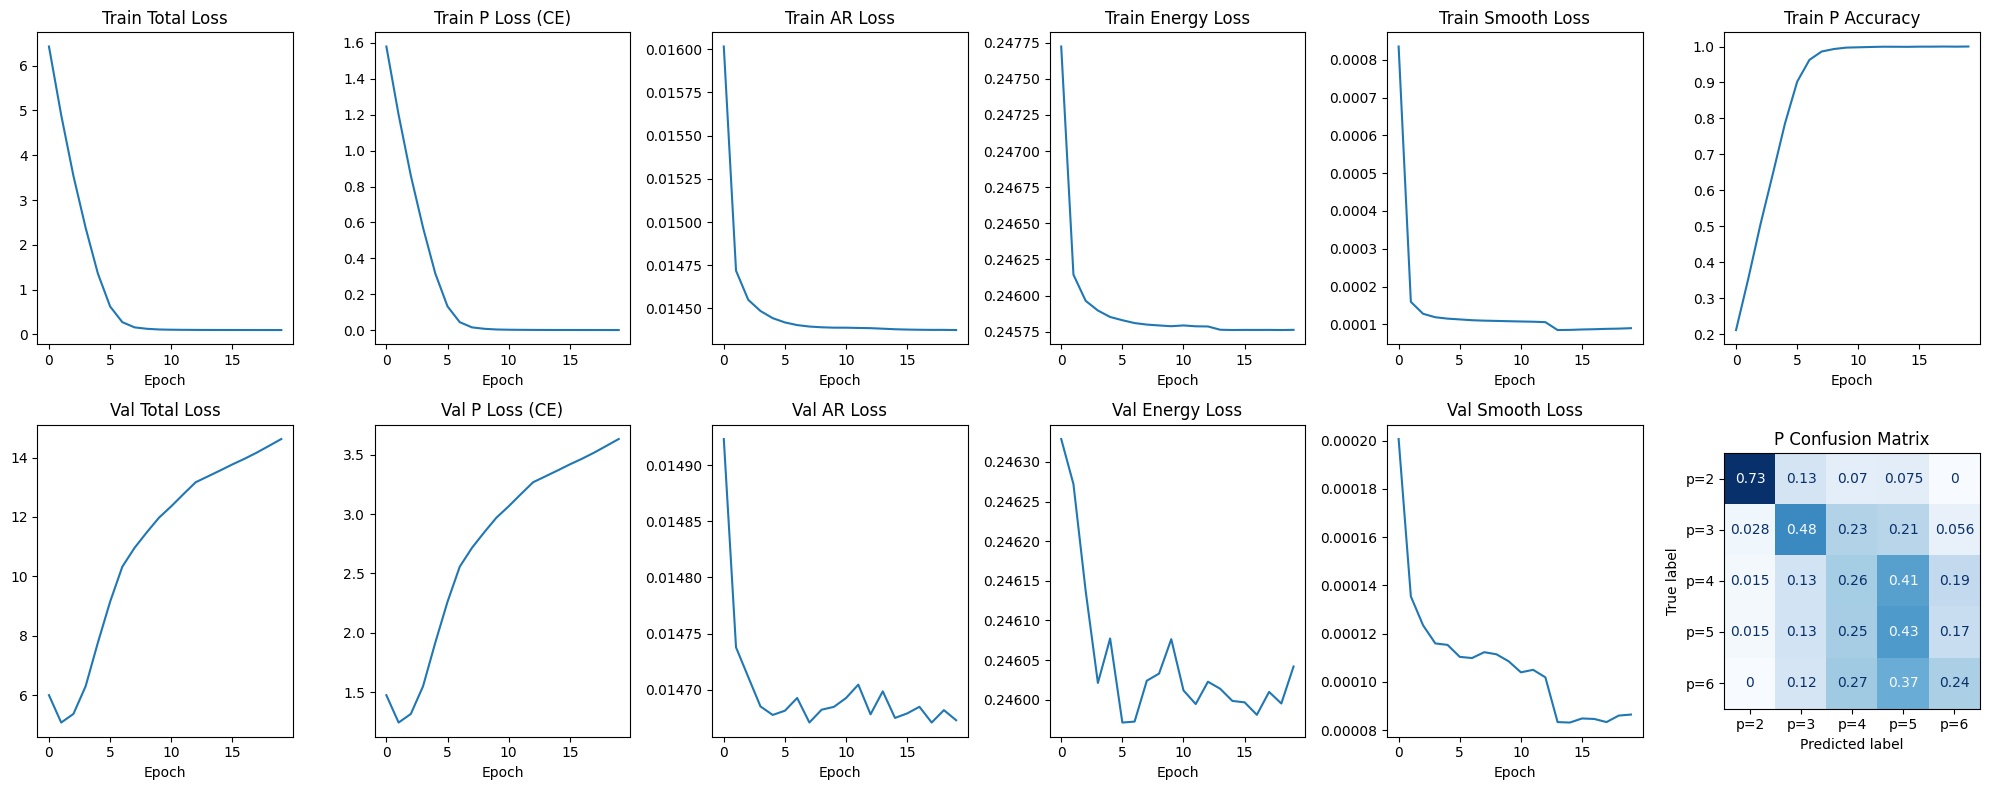

coeff_mse: 0.003621787573972331
signal_mse: 0.014682672917842865
p2_acc: 0.7711442786069652
p3_acc: 0.4719626168224299
p4_acc: 0.2524752475247525
p5_acc: 0.4228855721393035
p6_acc: 0.27472527472527475
p_acc: 0.442


In [ ]:
config = {
    "lambda_ar": 5.0,
    "lambda_p": 4.0,
    "lambda_order": 0,
    "lambda_energy": 0.1,
    "lambda_smooth": 3
},

model, history = do_bench_on_config(config)
plot_history(history, model=model, val_loader=val_loader, device=device)
full_bench_results = bench_loop(model, X_val, coef_val, p_val, device)
for k, v in full_bench_results.items():
    print(f"{k}: {v}")

In [ ]:
import pandas as pd

ablation_df = pd.DataFrame({
    'full': full_bench_results,
    'no_ar': no_ar_bench_results,
    'no_p': no_p_bench_results,
    'no_energy': no_energy_bench_results,
    'no_smooth': no_smooth_bench_results
}).T

ablation_df

,coeff_mse,signal_mse,p2_acc,p3_acc,p4_acc,p5_acc,p6_acc,p_acc
full,0.003622,0.014683,0.771144,0.471963,0.252475,0.422886,0.274725,0.442
no_ar,4.401848,0.518360,0.726368,0.509346,0.316832,0.318408,0.230769,0.425
no_p,0.003320,0.014656,0.000000,0.000000,0.000000,0.000000,1.000000,0.182
no_energy,0.003524,0.014697,0.691542,0.500000,0.351485,0.407960,0.252747,0.445
no_smooth,0.217478,0.015977,0.701493,0.495327,0.237624,0.398010,0.230769,0.417
